# Airport Delays in the US

<img src="mapImages/Pipeline.png" style="width: 600px;"/>

In [2]:
## Imports
import urllib2, urllib, json, requests, os, random, time, csv, os.path, warnings  
import numpy as np
import pandas as pd
import threading
#from threading import Thread
#import threading
import psycopg2
from pprint import pprint
from urllib2 import HTTPError
from datetime import datetime
from mpl_toolkits.basemap import Basemap
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import array_contains
#from pyspark.streaming.kafka import KafkaUtils
#from cassandra.cluster import Cluster
import sqlalchemy
from sqlalchemy.engine.url import URL
from sqlalchemy.engine import create_engine
from sqlalchemy import Table, Column, Integer, String, ForeignKey
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
% matplotlib inline

## FAA Airport Delays RESTful API 

Source: http://services.faa.gov/docs/basics/

In [4]:
result = urllib2.urlopen("http://services.faa.gov/airport/status/SFO?format=application/json").read()
d = json.loads(result)
pprint(d)

{u'IATA': u'SFO',
 u'ICAO': u'KSFO',
 u'city': u'San Francisco',
 u'delay': u'false',
 u'name': u'San Francisco International',
 u'state': u'California',
 u'status': {u'avgDelay': u'',
             u'closureBegin': u'',
             u'closureEnd': u'',
             u'endTime': u'',
             u'maxDelay': u'',
             u'minDelay': u'',
             u'reason': u'No known delays for this airport.',
             u'trend': u'',
             u'type': u''},
 u'weather': {u'meta': {u'credit': u"NOAA's National Weather Service",
                        u'updated': u'1:56 PM Local',
                        u'url': u'http://weather.gov/'},
              u'temp': u'69.0 F (20.6 C)',
              u'visibility': 10.0,
              u'weather': u'A Few Clouds',
              u'wind': u'Northwest at 17.3mph'}}


## OurAirports CSV API

Source: http://ourairports.com/data/

In [5]:
df = pd.read_csv('airports.csv')
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


To speed things up, we only take the columns in the US.

In [6]:
us_df = df[df['iso_country']=='US']
us_df.to_csv('us_airports.csv')

### Convert CSV to JSON

In [7]:
csvfile = open('us_airports.csv', 'r')
jsonfile = open('us_airports.json', 'w')

fieldnames = df.columns
reader = csv.DictReader( csvfile, fieldnames)
for row in reader:
    json.dump(row, jsonfile)
    jsonfile.write('\n')
csvfile.close()
jsonfile.close()

### Connect to Postgres

(Don't forget to connect to the server locally!)

# Airport Delay Analysis

In [20]:
APP_NAME = "Airport Delay Analysis"

def plot_map(q):
    
    '''
    Plot scatter plot of airports across the US.
    Based on delay status. 
    '''
    
    #Convert RDD to matrix
    dfp = q.toDF().toPandas().as_matrix()
    fig = plt.figure(figsize=(20,10))
    delayed = dfp[:,2]

    #Draw map
    rgba_colors = np.zeros((len(dfp),4))
    rgba_colors[:,0] = [1.0 if i == 'true' else 0 for i in delayed] #red
    rgba_colors[:,2] = [1.0 if i == 'false' else 0 for i in delayed] #blue
    rgba_colors[:, 3] = [1.0 if i == 'true' else 0.5 for i in delayed] #opacity (alphas)
    #size = [20 if i == 'true' else 20 for i in delayed] #size
    
    #Map image 
    m = Basemap(width=12000000,height=9000000,projection='lcc',
                resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
    m.shadedrelief()
    lats, lons = m(dfp[:,0], dfp[:,1])

    #Plot airports
    m.scatter(lats,lons,20,marker='o',color=rgba_colors)
    now = datetime.now()
    plt.title('Airport Delays in the US on {}'.format(now.strftime("%m/%d/%Y at %H:%M")))
    plt.draw()
    ImagetoPostgres(fig)

def JSONtoPostgres(x):
    
    '''
    Save JSON to Postgres
    '''
    #import username and password for postgres
    with open('/Users/theresa/postgres.json') as f:
        data = json.load(f)
        user = data['user'] 
        password = data['password']
    try:
        conn = psycopg2.connect("dbname='finalproject' user='{}' host='localhost' password='{}'".format(user,password))
        x0 = json.dumps(x)
        cur = conn.cursor()
        cur.execute("INSERT INTO delaytable (data) VALUES(%s);",(x0,))
    except:
        print "JSONtoPostgres didn't work!"
        pass
    
def ImagetoPostgres(x):
    
    '''
    Save Images to Postgres
    '''
    #import username and password for postgres
    with open('/Users/theresa/postgres.json') as f:
        data = json.load(f)
        user = data['user'] 
        password = data['password']
    try:
        b = bytearray(x)
        conn = psycopg2.connect("dbname='finalproject' user='{}' host='localhost' password='{}'".format(user,password))
        cur = conn.cursor()
        cur.execute("INSERT INTO mapImages (Data) VALUES(%s);",(b,))
    except:
        print "ImagetoPostgres didn't work!"
        pass
    
def process(rdd):
    
    '''
    Main functionality
    '''
    
    sqlContext = SQLContext(sc)
    delay_df = sqlContext.jsonRDD(rdd).registerTempTable("delay")
    query0 = sqlContext.sql("SELECT DISTINCT d.IATA, d.status.reason, \
                            d.weather.temp, d.weather.weather \
                            FROM delay d WHERE delay = 'true' ")
    query0.show()
    
    #batch
    airports_df = sqlContext.read.json("airports.json")
    airports_df.registerTempTable("airport")
    
    #merging dataframes
    merged_df = sqlContext.sql(
        "SELECT delay.IATA, delay.delay, \
        airport.latitude_deg, airport.longitude_deg \
        FROM delay INNER JOIN airport \
        ON delay.IATA=airport.iata_code")
    
    # Plot map
    coords = merged_df.rdd.map(lambda r: (r.longitude_deg, r.latitude_deg, r.delay))
    plot_map(coords)
    


if __name__ == "__main__":
    #Configure Spark 
    sc = SparkContext()
    ssc = StreamingContext(sc, 30)  
    #data_path = "file:///Users/theresa/Desktop/delayData/"
    data_path = "./delayData"
    #rdd = sc.textFile(data_path) 
    #rdd_queue = [rdd]
    #stream = ssc.queueStream(rdd_queue)
    stream = ssc.textFileStream(data_path)
    
    #Execute Main functionality
    stream.foreachRDD(process)
    ssc.start()

In [21]:
try: 
    sc.stop() 
    ssc.stop()
except NameError:
    pass

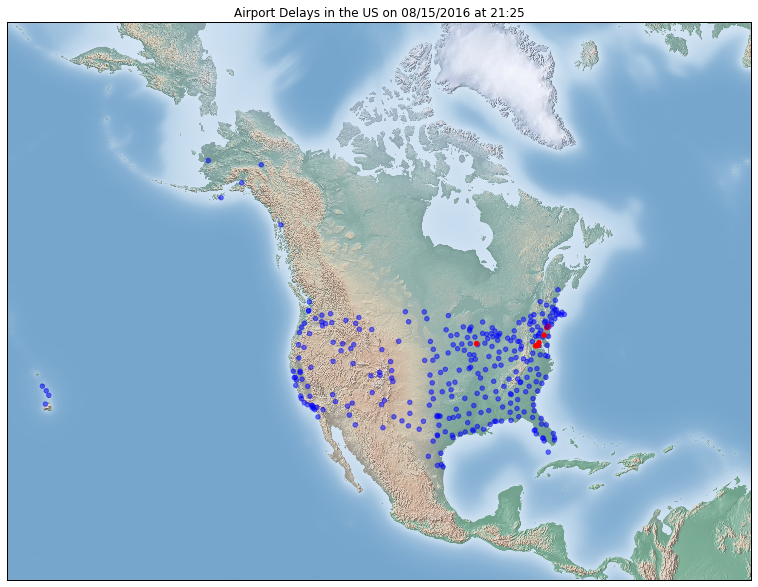

In [15]:
try: 
    sc.stop() 
    ssc.stop()
except NameError:
    pass

+----+--------------------+---------------+--------------------+
|IATA|              reason|           temp|             weather|
+----+--------------------+---------------+--------------------+
| DCA|WEATHER / THUNDER...|82.0 F (27.8 C)|        Thunderstorm|
| BWI|WEATHER / THUNDER...|73.0 F (22.8 C)|Thunderstorm Heav...|
| IAD|    WX:Thunderstorms|81.0 F (27.2 C)|            Overcast|
| CLT|WEATHER / THUNDER...|79.0 F (26.1 C)|Thunderstorm Ligh...|
| PHL|TM Initiatives:SW...|91.0 F (32.8 C)|       Mostly Cloudy|
| LGA|TM Initiatives:SW...|88.0 F (31.1 C)|       Mostly Cloudy|
+----+--------------------+---------------+--------------------+



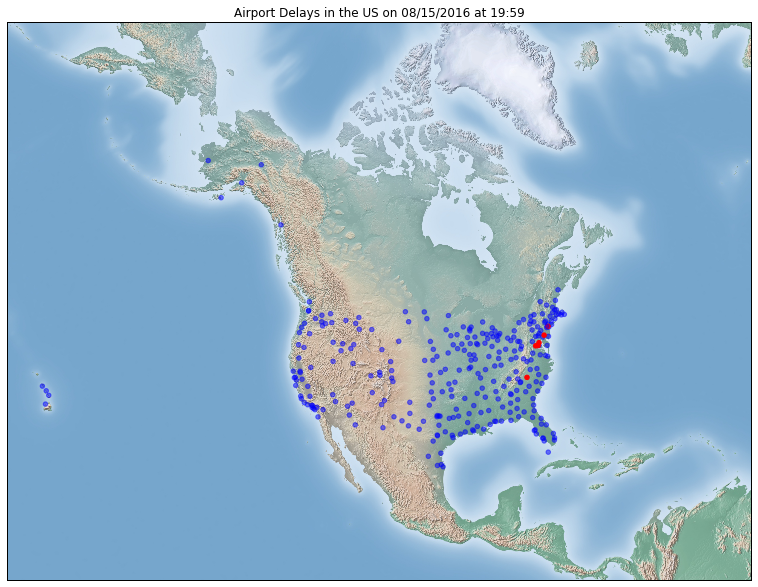

In [11]:
try: 
    sc.stop() 
    ssc.stop()
except NameError:
    pass